# Logistic regression

A bank wants to find out how many of the new credit applicants are actually credit worthy. Based on historical data (df) a model will be built and then applied to the applicants dataset (to_score)

## Imports 

In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn import linear_model
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE

In [45]:
df = pd.read_excel('/Users/jackfederle/Documents/python/credit-data-training.xlsx')
to_score = pd.read_excel('/Users/jackfederle/Documents/python/customers-to-score.xlsx')

In [46]:
to_score.head(3)

,Account-Balance,Duration-of-Credit-Month,Payment-Status-of-Previous-Credit,Purpose,Credit-Amount,Value-Savings-Stocks,Length-of-current-employment,Instalment-per-cent,Guarantors,Duration-in-Current-address,Most-valuable-available-asset,Age-years,Concurrent-Credits,Type-of-apartment,No-of-Credits-at-this-Bank,Occupation,No-of-dependents,Telephone,Foreign-Worker
0,No Account,9,No Problems (in this bank),Home Related,2799,None,< 1yr,2,None,2,1,36,Other Banks/Depts,1,More than 1,1,2,1,1
1,No Account,12,No Problems (in this bank),Home Related,2122,None,< 1yr,3,None,2,1,39,Other Banks/Depts,1,More than 1,1,2,1,2
2,No Account,24,Paid Up,Home Related,3758,£100-£1000,< 1yr,1,None,4,4,23,Other Banks/Depts,1,1,1,1,1,1


## Data exploration and cleansing 

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 20 columns):
Credit-Application-Result            500 non-null object
Account-Balance                      500 non-null object
Duration-of-Credit-Month             500 non-null int64
Payment-Status-of-Previous-Credit    500 non-null object
Purpose                              500 non-null object
Credit-Amount                        500 non-null int64
Value-Savings-Stocks                 500 non-null object
Length-of-current-employment         500 non-null object
Instalment-per-cent                  500 non-null int64
Guarantors                           500 non-null object
Duration-in-Current-address          156 non-null float64
Most-valuable-available-asset        500 non-null int64
Age-years                            488 non-null float64
Concurrent-Credits                   500 non-null object
Type-of-apartment                    500 non-null int64
No-of-Credits-at-this-Bank           500 no

There are a lot of missing values for the variable Duration-in-Current-address, imputing seems to be not an option, so it will be dropped 

In [48]:
df = df.drop(['Duration-in-Current-address'], axis=1)

There are 12 missing values for the Age-years variable

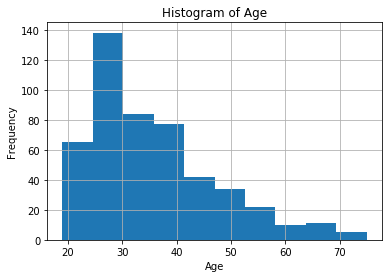

In [49]:
df['Age-years'].hist()
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

the missing values will be imputed with the median values

In [50]:
df['Age-years'] = df['Age-years'].fillna(df['Age-years'].median())

Variables with no variability are of no use for the model, so any variable with standard deviation equal to zero will be dropped

In [51]:
df.describe()

,Duration-of-Credit-Month,Credit-Amount,Instalment-per-cent,Most-valuable-available-asset,Age-years,Type-of-apartment,Occupation,No-of-dependents,Telephone,Foreign-Worker
count,500.00000,500.000000,500.000000,500.000000,500.000000,500.000000,500.0,500.00000,500.000000,500.000000
mean,21.43400,3199.980000,3.010000,2.360000,35.574000,1.928000,1.0,1.14600,1.400000,1.038000
std,12.30742,2831.386861,1.113724,1.064268,11.369567,0.539814,0.0,0.35346,0.490389,0.191388
min,4.00000,276.000000,1.000000,1.000000,19.000000,1.000000,1.0,1.00000,1.000000,1.000000
25%,12.00000,1357.250000,2.000000,1.000000,27.000000,2.000000,1.0,1.00000,1.000000,1.000000
50%,18.00000,2236.500000,3.000000,3.000000,33.000000,2.000000,1.0,1.00000,1.000000,1.000000
75%,24.00000,3941.500000,4.000000,3.000000,41.000000,2.000000,1.0,1.00000,2.000000,1.000000
max,60.00000,18424.000000,4.000000,4.000000,75.000000,3.000000,1.0,2.00000,2.000000,2.000000


In [52]:
df = df.drop(['Occupation'], axis=1)

In [53]:
df['Concurrent-Credits'].unique()

array(['Other Banks/Depts'], dtype=object)

Concurrent-Credits having only one category will not make for a good predictor variable

In [54]:
df = df.drop(['Concurrent-Credits'], axis=1)

#### Target variable exploration

The next step is to explore the relation among the variables. To then pick the predictor variables for the model, the recursive feature elimination will be applied, more on this later. 

#### Target variable, credit application result

In [55]:
df.groupby('Credit-Application-Result').mean()

,Duration-of-Credit-Month,Credit-Amount,Instalment-per-cent,Most-valuable-available-asset,Age-years,Type-of-apartment,No-of-dependents,Telephone,Foreign-Worker
Credit-Application-Result,,,,,,,,,
Creditworthy,19.865922,2840.229050,2.966480,2.265363,35.952514,1.918994,1.136872,1.391061,1.039106
Non-Creditworthy,25.387324,4106.957746,3.119718,2.598592,34.619718,1.950704,1.169014,1.422535,1.035211


At first glance it looks like Type-of-apartment, No-of-dependents and Foreign-Worker may not very significant. On the other hand, the duration of the credit and the amount credited seems to be interesting variables to consider

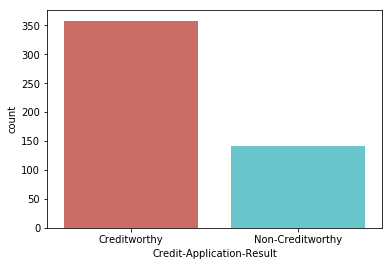

In [56]:
sns.countplot(x = 'Credit-Application-Result', data = df, palette = 'hls')
plt.show()

#### Payment status of previous credit

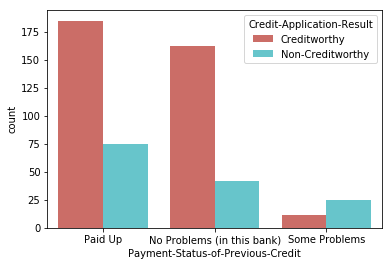

In [57]:
sns.countplot(data = df, x = 'Payment-Status-of-Previous-Credit', hue = 'Credit-Application-Result', palette = 'hls')
plt.show()

In [58]:
df.groupby('Payment-Status-of-Previous-Credit').mean()

,Duration-of-Credit-Month,Credit-Amount,Instalment-per-cent,Most-valuable-available-asset,Age-years,Type-of-apartment,No-of-dependents,Telephone,Foreign-Worker
Payment-Status-of-Previous-Credit,,,,,,,,,
No Problems (in this bank),22.088235,3291.720588,3.058824,2.411765,38.147059,2.000000,1.156863,1.436275,1.044118
Paid Up,20.134615,3004.515385,2.965385,2.257692,33.757692,1.880769,1.130769,1.376923,1.030769
Some Problems,27.111111,4091.805556,3.055556,2.805556,34.111111,1.861111,1.194444,1.361111,1.055556


The more problems the longer the duration of the credit. It seems that larger amounts are correlated with problems. 

#### Account Balance

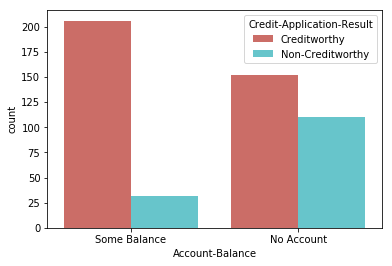

In [59]:
sns.countplot(data = df, x = 'Account-Balance', hue = 'Credit-Application-Result', palette = 'hls')
plt.show()

It is not surprising to see how having some balance in their accounts favourites the credit applicants.

#### Purpose

In [60]:
df.groupby('Purpose').mean()

,Duration-of-Credit-Month,Credit-Amount,Instalment-per-cent,Most-valuable-available-asset,Age-years,Type-of-apartment,No-of-dependents,Telephone,Foreign-Worker
Purpose,,,,,,,,,
Home Related,21.425352,3024.952113,3.090141,2.323944,35.963380,1.943662,1.157746,1.397183,1.036620
New car,26.191489,5200.255319,2.680851,2.851064,37.936170,2.000000,1.191489,1.531915,1.021277
Other,20.000000,3271.066667,3.333333,2.066667,34.600000,1.800000,1.133333,1.333333,1.133333
Used car,19.036145,2803.060241,2.795181,2.289157,32.746988,1.843373,1.072289,1.349398,1.036145


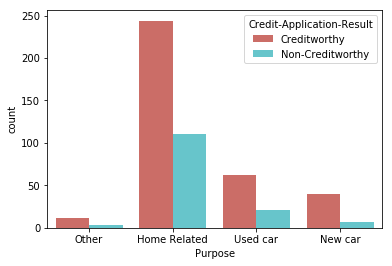

In [61]:
sns.countplot(data = df, x = 'Purpose', hue = 'Credit-Application-Result', palette = 'hls')
plt.show()

Home related credits are the most common, in proportion the most likely to be financed are those who apply for credit for a new car. 

#### Value Savings Stocks

In [62]:
df.groupby('Value-Savings-Stocks').mean()

,Duration-of-Credit-Month,Credit-Amount,Instalment-per-cent,Most-valuable-available-asset,Age-years,Type-of-apartment,No-of-dependents,Telephone,Foreign-Worker
Value-Savings-Stocks,,,,,,,,,
< £100,23.208333,3272.187500,3.104167,2.729167,33.895833,1.875000,1.145833,1.437500,1.000000
None,21.265101,3214.137584,2.986577,2.328859,35.338926,1.946309,1.137584,1.372483,1.050336
£100-£1000,21.207792,3150.077922,3.025974,2.305195,36.551948,1.909091,1.162338,1.441558,1.025974


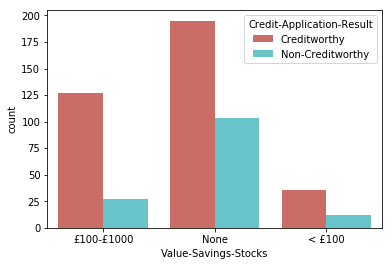

In [63]:
sns.countplot(data = df, x = 'Value-Savings-Stocks', hue = 'Credit-Application-Result', palette = 'hls')
plt.show()

Having stocks seems to have quite an impact on the outcome of the credit application. 

#### Length of current employment

In [64]:
df.groupby('Length-of-current-employment').mean()

,Duration-of-Credit-Month,Credit-Amount,Instalment-per-cent,Most-valuable-available-asset,Age-years,Type-of-apartment,No-of-dependents,Telephone,Foreign-Worker
Length-of-current-employment,,,,,,,,,
1-4 yrs,21.402062,2835.649485,3.051546,2.402062,32.639175,1.835052,1.154639,1.402062,1.010309
4-7 yrs,21.669355,3168.129032,3.306452,2.604839,43.000000,2.080645,1.193548,1.459677,1.032258
< 1yr,21.340502,3340.802867,2.863799,2.236559,33.293907,1.892473,1.121864,1.372760,1.050179


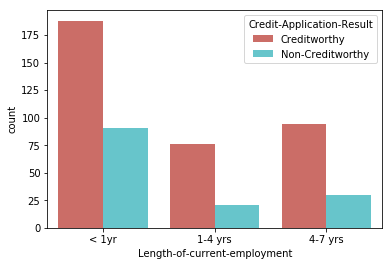

In [65]:
sns.countplot(data = df, x = 'Length-of-current-employment', hue = 'Credit-Application-Result', palette = 'hls')
plt.show()

While most of those who apply for credit have been in their current job for less than a year, in proportion, those who have been in their job for longer, are more likely to receive credit. 

## Model building

Recursive feature elimination starts with all features, builds a model, and discards the least important feature according to the model. 

In [66]:
df['Credit-Application-Result']=np.where(df['Credit-Application-Result'] =='Creditworthy', 1, df['Credit-Application-Result'])
df['Credit-Application-Result']=np.where(df['Credit-Application-Result'] =='Non-Creditworthy', 0, df['Credit-Application-Result'])
df = df.rename(index=str, columns={"Credit-Application-Result": "target"})

In [67]:
df = pd.get_dummies(df)

In [68]:
X_train, X_test, y_train, y_test = train_test_split(df, df['target_0'], random_state = 0, test_size = .35)

In [69]:
logreg = linear_model.LogisticRegression()

In [70]:
rfe = RFE(logreg)
rfe = rfe.fit(X_train, y_train)

In [71]:
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)
score = linear_model.LogisticRegression().fit(X_train_rfe, y_train).score(X_test_rfe, y_test)
print('Test score: {:.3f}'.format(score))

Test score: 1.000


In [72]:
predict_test = rfe.predict(X_test)

In [73]:
auc = roc_auc_score(y_test, predict_test)
print('AUC: {:.3f}'.format(auc))

AUC: 1.000


Score and AUC values are really high, to the point I fear I may have overfit the model

## Prediction

In [74]:
to_score_dummies = pd.get_dummies(to_score)

In [75]:
prediction = rfe.predict(to_score_dummies)

In [76]:
to_score['prediction'] = prediction

In [77]:
to_score['prediction'] = to_score['prediction'].map({1 : 'Not_credit_worthy', 0 : 'Credit_worthy'})

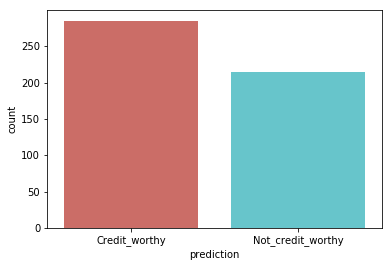

In [78]:
sns.countplot(x = 'prediction', data = to_score, palette = 'hls')
plt.show()

In [79]:
to_score['prediction'].value_counts()

Credit_worthy        285
Not_credit_worthy    215
Name: prediction, dtype: int64

Out of the 500 new credit applicants only 285 seems to be credit worthy according to the model.